In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

import helper_functions
reload(helper_functions)
from helper_functions import accuracy_rate, load_data, capacity, get_good_idx, get_slice, get_k_fold_cv_idx, get_x_sequences_ffnn, train, get_all_accuracy_rates, allocate_x_batch_ffnn, quantile_score




In [2]:
np.random.seed(2021)

case=1
x,x_time,y,y_time,time_dif,idx_offset = load_data(case)

# Index offset between start and end of training data for one single prediction
# i.e. number of quarters of an hour we wish to train on for each sample
pred_seq_len = 6*4+1


#i=1000
#print(target_time[i])
#print(x_time[i+idx_offset-pred_seq_len+1:i+idx_offset+1])

good_idx = get_good_idx(x,y,idx_offset,pred_seq_len)


print(x.shape)
print(y.shape)
print(x_time[0])
print(y_time[0])
print(len(good_idx))

torch.Size([182918, 16])
torch.Size([147205, 1])
2016-01-01 20:00:00
2017-01-07 20:15:00
137893


In [3]:
input_size = x.shape[1] * pred_seq_len
hidden_size1 = 50
hidden_size2 = 50
out_size = 1


# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  
        
        self.model = nn.Sequential(
            nn.Linear(in_features=input_size,
                      out_features=hidden_size1,
                      bias=True),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size1,
                      out_features=hidden_size2,
                      bias=True),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size2,
                      out_features=hidden_size2,
                      bias=True),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size2,
                      out_features=out_size,
                      bias=True)
        )
        
        


    def forward(self, x):
        x = self.model(x)
        return x


net = Net()
print(net)

Net(
  (model): Sequential(
    (0): Linear(in_features=400, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [4]:
# setting hyperparameters and gettings epoch sizes
batch_size = 10000
num_epochs = 10
k_fold_size = 5

loss = nn.MSELoss()


q=0.3
def quantile_score_metric(y, y_pred): 
    return quantile_score(y,y_pred,q)
def accuracy_rate_metric(y, y_pred): 
    return accuracy_rate(y*capacity(case),y_pred*capacity(case),capacity(case))
def mseloss(*args): 
    return nn.MSELoss()(*args)
def maeloss(*args):
    return nn.L1Loss()(*args)
valid_metrics = [mseloss, maeloss, quantile_score_metric, accuracy_rate_metric]


train_loss, valid_loss = train('ffnn', x, y, net, num_epochs, batch_size, good_idx, k_fold_size, idx_offset, pred_seq_len, loss, valid_metrics)
valid_loss[0] = np.sqrt(valid_loss[0])

Epoch  0 : Training loss: 0.0757, 
Validation metrics: 
mseloss 0.0468 
maeloss 0.1619 
quantile_score_metric 0.0753 
accuracy_rate_metric 0.7838 

Epoch  1 : Training loss: 0.0440, 
Validation metrics: 
mseloss 0.0404 
maeloss 0.1499 
quantile_score_metric 0.0746 
accuracy_rate_metric 0.7990 

Epoch  2 : Training loss: 0.0400, 
Validation metrics: 
mseloss 0.0392 
maeloss 0.1472 
quantile_score_metric 0.0772 
accuracy_rate_metric 0.8021 

Epoch  3 : Training loss: 0.0379, 
Validation metrics: 
mseloss 0.0371 
maeloss 0.1400 
quantile_score_metric 0.0705 
accuracy_rate_metric 0.8075 

Epoch  4 : Training loss: 0.0364, 
Validation metrics: 
mseloss 0.0360 
maeloss 0.1375 
quantile_score_metric 0.0687 
accuracy_rate_metric 0.8103 

Epoch  5 : Training loss: 0.0352, 
Validation metrics: 
mseloss 0.0349 
maeloss 0.1353 
quantile_score_metric 0.0677 
accuracy_rate_metric 0.8131 

Epoch  6 : Training loss: 0.0342, 
Validation metrics: 
mseloss 0.0342 
maeloss 0.1339 
quantile_score_metric 0.

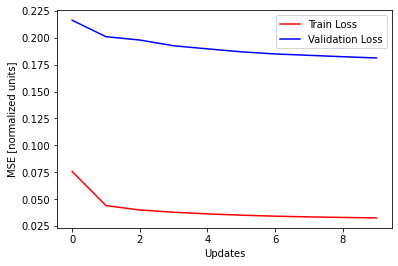

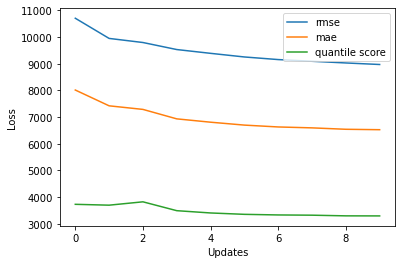

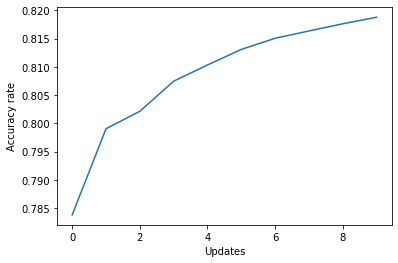

In [10]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', epoch, valid_loss[0, :], 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('MSE [normalized units]')
plt.show()


plt.figure()
plt.plot(epoch, capacity(case)*np.array(valid_loss[:-1]).T)
plt.legend(['rmse','mae','quantile score'])
plt.xlabel('Updates'), plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(epoch, valid_loss[-1])
plt.xlabel('Updates'), plt.ylabel('Accuracy rate')
plt.show()


In [6]:
x_batch = allocate_x_batch_ffnn(len(good_idx), input_size, pred_seq_len)
predictions = net(get_x_sequences_ffnn(good_idx, x_batch, idx_offset, pred_seq_len, x)).detach().numpy()

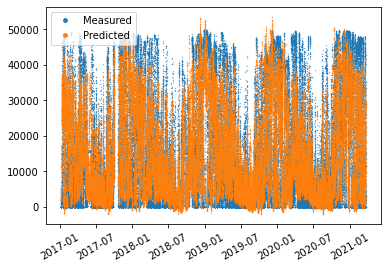

In [7]:
plt.plot(y_time[good_idx], capacity(case)*y[good_idx].detach().numpy(), '.', markersize=0.5, label = 'Measured')
plt.plot(y_time[good_idx], capacity(case)*predictions,'.', markersize=0.5, label = 'Predicted')
lgnd = plt.legend(markerscale=15)    
plt.xticks(rotation=30)
plt.show()

In [8]:
x_batch = allocate_x_batch_ffnn(96, input_size, pred_seq_len)
accuracies, times = get_all_accuracy_rates(net, x, y, y_time, x_batch, get_x_sequences_ffnn, good_idx, idx_offset, pred_seq_len, case)



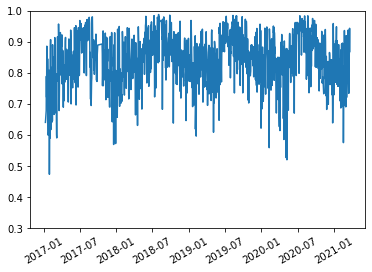

Mean accuracy rate 0.8429321


In [9]:
plt.plot(times, accuracies)
plt.xticks(rotation=30)
plt.ylim(0.3,1)
plt.show()
print('Mean accuracy rate', np.mean(accuracies))